In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 
from shutil import copyfile
from tqdm import tqdm
import glob
import os
from keras import backend as K
from imp import reload
import os
import numpy as np
import cv2
from keras.preprocessing import image                  
from skimage import data, io, filters
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from skimage.morphology import square
from skimage.filters.rank import mean_bilateral
from skimage.morphology import erosion, dilation

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend
set_keras_backend('tensorflow')

C:\Users\lleti\AppData\Local\conda\conda\envs\deepl\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### PREPROCESSING FUNCTION
import numpy as np
import cv2

iclahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(32, 32))
# All images are preprocessed for unbalanced brightness and contrast and resized to 256 by 256
def preprocess(image):   
    image = cv2.GaussianBlur(image,(5,5),0)  
    n_image = iclahe.apply(np.uint8(image))
    final = np.array(n_image,dtype=np.float32)
    final = (final-np.min(final))/(np.max(final)-np.min(final)) # Normalization has to be done AFTER AUGMENTATION
    return final

def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    final = cv2.resize(img,(256,256))
    final = preprocess(final)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 1) and return 4D tensor    
    return np.expand_dims(final, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:

# Load TEST images
sample_test = [] 
# Load data
dirSample = ".\\data\\crosses"
#flist = glob.glob(dirSample + "\\*TEST*\\f*")
flist = glob.glob(dirSample + "\\*TEST3*\\f*")
flistdir= [f for f in flist if os.path.isdir(f)]
if flistdir is None:
        raise Exception('--scanfolder not found')

for sample in flistdir:
    flist2 = glob.glob(sample + "\\ref*.tif")
    for el in flist2:
        sample_test.append(el)

test_tensors = paths_to_tensor(sample_test)
test_tensors = np.expand_dims(test_tensors, axis=3)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 153.83it/s]


In [4]:
# load json and create model
from keras.models import model_from_json
json_file = open('model_CROSS_DETECTOR.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
# loaded_model.load_weights('weights.bestM_UNET.from_scratch.hdf5')
loaded_model.load_weights('weights.model_CROSS_DETECTOR.hdf5')
print("Loaded model from disk")

Loaded model from disk


In [5]:
y_test = loaded_model.predict(test_tensors)  

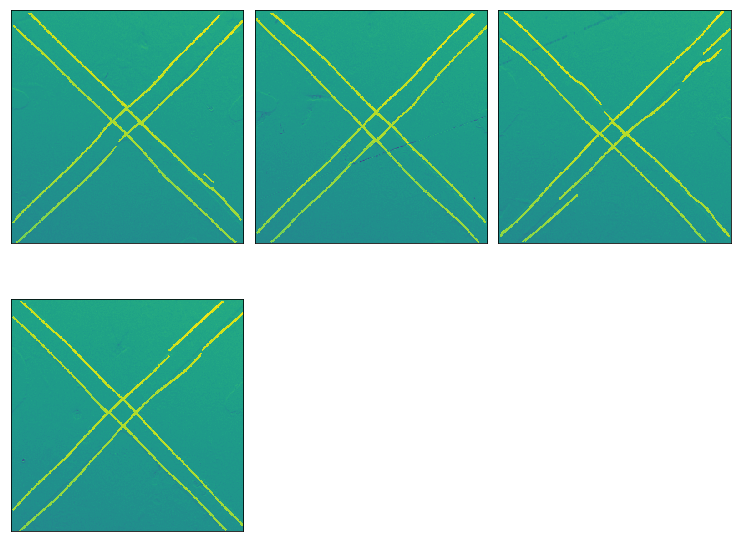

In [6]:
%load_ext autoreload
%autoreload 2
from math import sqrt
from common_analysis import derivative5,borderEnhancer
from skimage.morphology import skeletonize
from cross_detector_utils import *
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)


theta_plus = [ np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17, 0.17, num=5) ]
theta_minus = [ -np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17,0.17,num=5)]
ftheta = theta_plus+theta_minus

fig = plt.figure(figsize=(10,80))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(20, 3, i + 1, xticks=[], yticks=[])
    img = np.zeros((512,512,3),dtype = np.uint8)
    img1 = cv2.resize(test_tensors[i].reshape(256,256),(512,512))*255.
    img[:,:,:] = cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB)
    img_p0 =y_test[i,:,:]
    img_p = img_p0.reshape((256,256))
    img_p = cv2.resize(img_p,(512,512))
    imgw, fa = autoThreshold(img_p,0.1)
    skel = skeletonize(imgw>0)
    skel = borderEnhancer(skel,[2,2])
    lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20, theta = np.array(ftheta))
    im2 = np.zeros((512,512))
    for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    
    img_p1 = cv2.imread(sample_test[i],0)
    img = cv2.addWeighted(np.uint8(img_p1),0.8,np.uint8(im2),0.2,0)
    ax.imshow(np.squeeze(img))
    name = ".\\results_t3\\"+str(i)+"_cross_nn_prob.tif"
    img = img[...,::-1]

    cv2.imwrite(name,img)
   

In [7]:
len(sample_test)

4

0
Angle sum :90.0
[134 119]
1
Angle sum :90.0
[141 116]
2
Angle sum :90.0
[132 138]
3
Angle sum :90.0
[131 122]


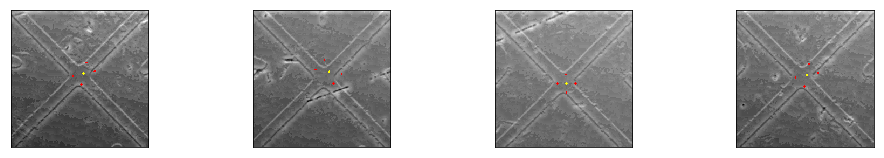

In [8]:
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0,4):
    print(i)
    ax = fig.add_subplot(20, 6, i + 1, xticks=[], yticks=[])
    img = test_tensors[i,:,:]
    img = img.reshape((256,256))
    img_p =y_test[i,:,:]
    img_p = img_p.reshape((256,256))
    imgw, fa = autoThreshold(img_p,0.1)
    skel = skeletonize(imgw>0)
    skel = borderEnhancer(skel,[2,2])
    lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20, theta = np.array(ftheta))
    im2 = np.zeros((256,256))
    for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    imgw[im2<255]=0
    fpeaks_pos, fpeaks_neg, _ = getPeaks(img,imgw,[35])
    if fpeaks_pos.shape[0] == 0 or  fpeaks_neg.shape[0] == 0 :
        fpeaks_pos, fpeaks_neg,_ = getPeaks(img, imgw, [18])
        if fpeaks_pos.shape[0] == 0 or fpeaks_neg.shape[0] == 0:
            print("No peaks found")
            iimgc = np.zeros((256,256,3))
        else:    
            cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
            print(cpoint)
    else:    
        cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
        print(cpoint)
    ax.imshow(np.squeeze(iimgc))
    name = ".\\results_t3\\"+str(i)+"_cross_nn.tif"
    iimgc = cv2.resize(iimgc,(512,512))
    iimgc = iimgc[...,::-1]
    cv2.imwrite(name,iimgc)

In [9]:
## Read information of crossings. 
## What do we need? 
## Set of images from the crosses - from 30 to 100 recommended, the more the better
## Set of images from the crosses segmented (equivalent)
## If possible, for validation, the crossing center in pixel coordinates. This will be used in part II.
sample = {}
sample['origin'] = []
sample['target_point'] = []
sample['target_im']=[]

k=0
# Load data
dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\*SCAN*")
flistdir= [f for f in flist if os.path.isdir(f)]
if flistdir is None:
        raise Exception('--scanfolder not found')

for sample_file in tqdm(flistdir):
    flist2 = glob.glob(sample_file + "\\*cross_det_ref_*\\*fpoints_pixels.csv*")
    
    # flist3 = glob.glob(sample +"\\*ref*.tif")
    for infile in flist2:
            letter = infile[-21:-19] 
            flist4 = glob.glob(sample_file +"\\*ref*_"+letter+"_*.tif")
            head,tail = os.path.split(infile)
            if flist4:
                    sample['target_point'].append(infile) 
                    sample['origin'].append(flist4[0])
                    sample['target_im'].append(head+"\\lines.tif")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]


In [10]:
# Method 1
import csv
y = np.empty((0,2)) #,dtype = np.int32)
f = 0.5 #scale from resolution to 256 to 256, in this case 256/512 = 0.5
for csvfile in sample['target_point']:
    with open(csvfile) as cs:
        readCSV = csv.reader(cs, delimiter=',')
        for row in readCSV:
            coords = row
        coords = [float(coords[0])*f,float(coords[1])*f]
        solution = np.array([coords[0],coords[1]],dtype=np.int32)
        y = np.vstack((y,solution))

In [11]:
train_tensors = paths_to_tensor(sample['origin'])

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 58.12it/s]


In [12]:
train_tensors = np.squeeze(train_tensors)

In [13]:
train_tensors = np.expand_dims(train_tensors, axis=3)
y_train = loaded_model.predict(train_tensors) 

In [14]:
il = train_tensors.shape[0]
tman = []
for i in range(il):
    img = train_tensors[i,:,:]
    img = img.reshape((256,256))
    img_p =y_train[i,:,:]
    img_p = img_p.reshape((256,256))
    imgw, fa = autoThreshold(img_p,0.1)
    skel = skeletonize(imgw>0)
    skel = borderEnhancer(skel,[2,2])
    lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20, theta = np.array(ftheta))
    im2 = np.zeros((256,256))
    for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    imgw[im2<255]=0
    
    
    fpeaks_pos, fpeaks_neg, _ = getPeaks(img,imgw,[35])
    if fpeaks_pos.shape[0] == 0 or  fpeaks_neg.shape[0] == 0 :
        fpeaks_pos, fpeaks_neg,_ = getPeaks(img, imgw, [18])
        if fpeaks_pos.shape[0] == 0 or fpeaks_neg.shape[0] == 0:
            print("No peaks found")
            iimgc = np.zeros((256,256,3))
            cpoint = np.array([np.inf,np.inf])
        else:    
            cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
            print(cpoint)
    else:    
        cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
    print(sample['origin'][i])
    print(str(i)+"_ Calculated : "+str(cpoint)+" Expected:"+str(y[i]))
    distpoints = np.sqrt((cpoint[0]-y[i,0])**2 + (cpoint[1]-y[i,1])**2)
    print("Distance : "+str(distpoints))
    max_dist_man = np.max([np.abs(cpoint[0]-y[i,0]),np.abs(cpoint[1]-y[i,1])])
    print("Max Manhattan:"+str(max_dist_man))
    print("-----------------------------------------------")
    name = ".\\results\\"+str(i)+"_cross_nn.tif"
    tman.append(max_dist_man)
    cv2.imwrite(name,iimgc)
print("Finished")

Angle sum :89.0
.\data\crosses\SCAN_25r\ref_0_3E_201702221645207963.tif
0_ Calculated : [126 127] Expected:[123. 127.]
Distance : 3.0
Max Manhattan:3.0
-----------------------------------------------
Angle sum :91.0
.\data\crosses\SCAN_25r\ref_0_3J_201702221641059125.tif
1_ Calculated : [141 130] Expected:[140. 130.]
Distance : 1.0
Max Manhattan:1.0
-----------------------------------------------
Angle sum :89.0
.\data\crosses\SCAN_25r\ref_0_3N_201702221719133119.tif
2_ Calculated : [129 124] Expected:[131. 122.]
Distance : 2.8284271247461903
Max Manhattan:2.0
-----------------------------------------------
Angle sum :91.0
.\data\crosses\SCAN_25r\ref_0_3O_201702221718271064.tif
3_ Calculated : [132 124] Expected:[131. 123.]
Distance : 1.4142135623730951
Max Manhattan:1.0
-----------------------------------------------
Angle sum :90.0
.\data\crosses\SCAN_25r\ref_0_3P_201702221638363277.tif
4_ Calculated : [144 116] Expected:[142. 115.]
Distance : 2.23606797749979
Max Manhattan:2.0
-----

KeyboardInterrupt: 

In [ ]:
## FORENSIC TESTING
i = 234

%load_ext autoreload
%autoreload 2
from math import sqrt
from common_analysis import derivative5,borderEnhancer
from skimage.morphology import skeletonize
from cross_detector_utils import *
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)


theta_plus = [ np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17, 0.17, num=5) ]
theta_minus = [ -np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17,0.17,num=5)]
ftheta = theta_plus+theta_minus

img = train_tensors[i,:,:]
img = img.reshape((256,256))
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
img_p =y_train[i,:,:]
img_p = img_p.reshape((256,256))

imgw, fa = autoThreshold(img_p,0.1)
skel = skeletonize(imgw>0)
skel = borderEnhancer(skel,[2,2])
lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20)
im2 = np.zeros((256,256))
for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    
img[:,:,0] = im2 # (imgw>0)*255
plt.imshow(np.squeeze(img))


In [ ]:
np.max(imgw)

In [ ]:
imgw[im2<255]=0
img = train_tensors[i,:,:]
img = cv2.resize(img,(256,256))
fpeaks_pos, fpeaks_neg, _ = getPeaks(img,imgw,[35])
if fpeaks_pos.shape[0] == 0 or  fpeaks_neg.shape[0] == 0 :
    fpeaks_pos, fpeaks_neg,_ = getPeaks(img, imgw, [18])
    if fpeaks_pos.shape[0] == 0 or fpeaks_neg.shape[0] == 0:
            print("No peaks found")
            iimgc = np.zeros((256,256,3))
    else:    
            cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
            print(cpoint)
else:    
        cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img*255),fpeaks_pos, fpeaks_neg)
        print(cpoint)
plt.imshow(np.squeeze(iimgc))

In [ ]:
fpeaks_pos, fpeaks_neg, R = getPeaks(img,imgw,[35])

In [ ]:
error = 0
orientations = calculateOrientations(img)
prj_pos = projections(imgw,orientations,aspace=[45], arange = 10)
prj_neg = projections(imgw,orientations,aspace=[-45], arange = 10)
peaks_pos, hnew = detectPeaksNMS(prj_pos, numpeaks = 6,threshold = 0.1, nhood = None)
peaks_neg, hnew = detectPeaksNMS(prj_neg, numpeaks = 6,threshold = 0.1, nhood = None)

In [ ]:
error,ppeaks,npeaks = discardwrongpeaks(prj_pos+prj_neg,peaks_pos,peaks_neg,[35])
error

In [ ]:
positivePairs = peaks_pos
negativePairs = peaks_neg
goodpeaks = []
error = 0    
error = enoughpeaks(positivePairs,negativePairs)
# Error can be 0, 1 or 2. I
anglepos = np.array([ peak[1] for peak in positivePairs ])
angleneg = np.array([ peak[1] for peak in negativePairs ])

In [ ]:
pos_ang = np.unique(anglepos)
neg_ang = np.unique(angleneg)
good_angles_pos = set()
good_angles_neg = set()

for elp in pos_ang:
         for eln in neg_ang:
            nty = elp+np.abs(eln)
            if(nty>85 and nty<95): #good combination
                good_angles_pos.add(elp)
                good_angles_neg.add(eln)

    
good_pos = [ positivePairs[ind] for ind,angle in enumerate(anglepos) if angle in good_angles_pos]
good_neg = [ negativePairs[ind] for ind,angle in enumerate(angleneg) if angle in good_angles_neg]


In [ ]:
positivePairs = findCrossSequence(good_pos,[35])
negativePairs = findCrossSequence(good_neg,[35])

In [ ]:
error = enoughpeaks(positivePairs,negativePairs)

In [ ]:
positivePairs = predictGrid(negativePairs,prj_pos+prj_neg,[35])

In [ ]:
len(positivePairs)

In [ ]:
negativePairs

In [ ]:
positivePairs

In [ ]:
error=0;
best_peaks = negativePairs
goodpeaks = []
best_peaks = np.squeeze(np.array(best_peaks))
R = np.array(prj_pos+prj_neg)
total_peaks = best_peaks.shape[0]
total_peaks

In [ ]:
angle = int(best_peaks[0,1]) # We assume that  the first is the highest signaling peak
# normalize to same angle
best_peaks[:,1]= angle 
cangle = 0
if(angle>0):
    cangle = angle - 90
else : 
    cangle = angle+90
    c180angle = cangle+90
    
signal = R[:,int(c180angle)].copy() # get complementary data  
speaks = nonmaxsup1D(signal,6,int(18*0.5),0.01)

fpeaks = np.zeros((6,3))
for i in range(6):
        fpeaks[i,0] = speaks[i,1]
        fpeaks[i,1] = cangle
        fpeaks[i,2] = speaks[i,0]
fpeaks   

In [ ]:
goodpeaks = findCrossSequence(fpeaks,[18])
goodpeaks

In [ ]:
# Could be that we have just one peak
origin = fpeaks[0,0]
max_l = R.shape[0]
goodpeaks = fpeaks[:2]
if fpeaks[1,2]<1e-6:
    print("ba")

direction = fpeaks[1,0] # Direction is second biggest peak
if(direction>origin):
    goodpeaks[1,0] = origin+gridsize
else:
    goodpeaks[1,0] = origin-gridsize
        
if(goodpeaks[1,0]>max_l or goodpeaks[0,1]<0):
    goodpeaks = []
    print("ba")
         

In [ ]:
goodpeaks

In [ ]:
fpeaks